<a href="https://colab.research.google.com/github/Yashvishe13/Deep-Learning/blob/main/Resnet_for_fruits_360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Dense, Input, Flatten
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob 
# import itertools

In [2]:
# Image size
IMAGE_SIZE = [100, 100]

# Training config
epochs = 16
batch_size = 128

In [3]:
# https://www.kaggle.com/moltean/fruits
!wget -nc https://lazyprogrammer.me/course_files/fruits-360.zip

--2021-12-19 11:34:27--  https://lazyprogrammer.me/course_files/fruits-360.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M  1.69MB/s    in 61s     

2021-12-19 11:35:28 (3.01 MB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [4]:
!unzip -nq fruits-360.zip

In [5]:
train_path = 'fruits-360/Training'
valid_path = 'fruits-360/Validation'

In [6]:
# Files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [7]:
# Useful for Number of classes
folders = glob(train_path + '/*')

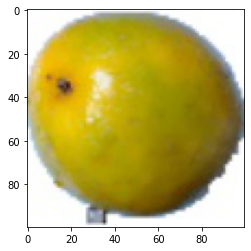

In [8]:
# Plotting random image
plt.imshow(image.load_img(np.random.choice(image_files)));

In [9]:
# Resnet
res = ResNet50(input_shape=IMAGE_SIZE + [3],  weights='imagenet', include_top=False)

# Freeze layers
for layers in res.layers:
  layers.trainable = False

x = Flatten() (res.output)
prediction = Dense(len(folders), activation='softmax')(x)

# Model
model = Model(inputs=res.inputs, outputs=prediction)
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization

In [10]:
# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [11]:
# Create an instance of generator
train_gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [12]:
# Testing generator
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 9673 images belonging to 60 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -104.779 max: 151.061


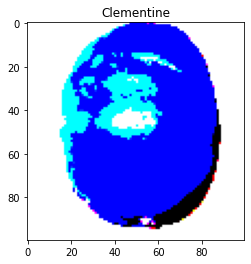

In [13]:
# Checking image from generator
for x, y in test_gen:
  print('min:', x[0].min(), 'max:', x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [14]:
# create generators
train_generators = train_gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse'
)

valid_generators = val_gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=batch_size,
    class_mode='sparse'
)

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


In [15]:
# Fit the model
r = model.fit(
    train_generators,
    validation_data=valid_generators,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size
)

Epoch 1/16
224/224 [==============================] - 136s 552ms/step - loss: 0.6211 - accuracy: 0.9171 - val_loss: 0.1829 - val_accuracy: 0.9656
Epoch 2/16
224/224 [==============================] - 123s 547ms/step - loss: 0.1544 - accuracy: 0.9761 - val_loss: 0.1431 - val_accuracy: 0.9739
Epoch 3/16
224/224 [==============================] - 124s 551ms/step - loss: 0.0953 - accuracy: 0.9862 - val_loss: 0.1855 - val_accuracy: 0.9801
Epoch 4/16
224/224 [==============================] - 122s 543ms/step - loss: 0.1219 - accuracy: 0.9841 - val_loss: 0.0864 - val_accuracy: 0.9852
Epoch 5/16
224/224 [==============================] - 120s 537ms/step - loss: 0.1040 - accuracy: 0.9877 - val_loss: 0.1402 - val_accuracy: 0.9802
Epoch 6/16
224/224 [==============================] - 120s 536ms/step - loss: 0.0991 - accuracy: 0.9898 - val_loss: 0.2884 - val_accuracy: 0.9724
Epoch 7/16
224/224 [==============================] - 120s 537ms/step - loss: 0.0820 - accuracy: 0.9908 - val_loss: 0.5526 -

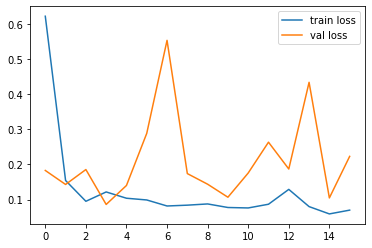

In [16]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

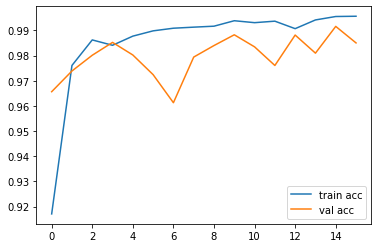

In [17]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [18]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  n_images = 0
  for x, y in val_gen.flow_from_directory(
      data_path,
      target_size=IMAGE_SIZE,
      shuffle=False,
      batch_size=batch_size * 2):
    i += 1
    n_images += len(y)
    if i % 50 == 0:
      print(f'{n_images} images processed.')
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [19]:
cm = get_confusion_matrix(train_path, len(image_files))
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))

Generating confusion matrix 28736
Found 28736 images belonging to 60 classes.
12800 images processed.
25600 images processed.
Generating confusion matrix 9673
Found 9673 images belonging to 60 classes.


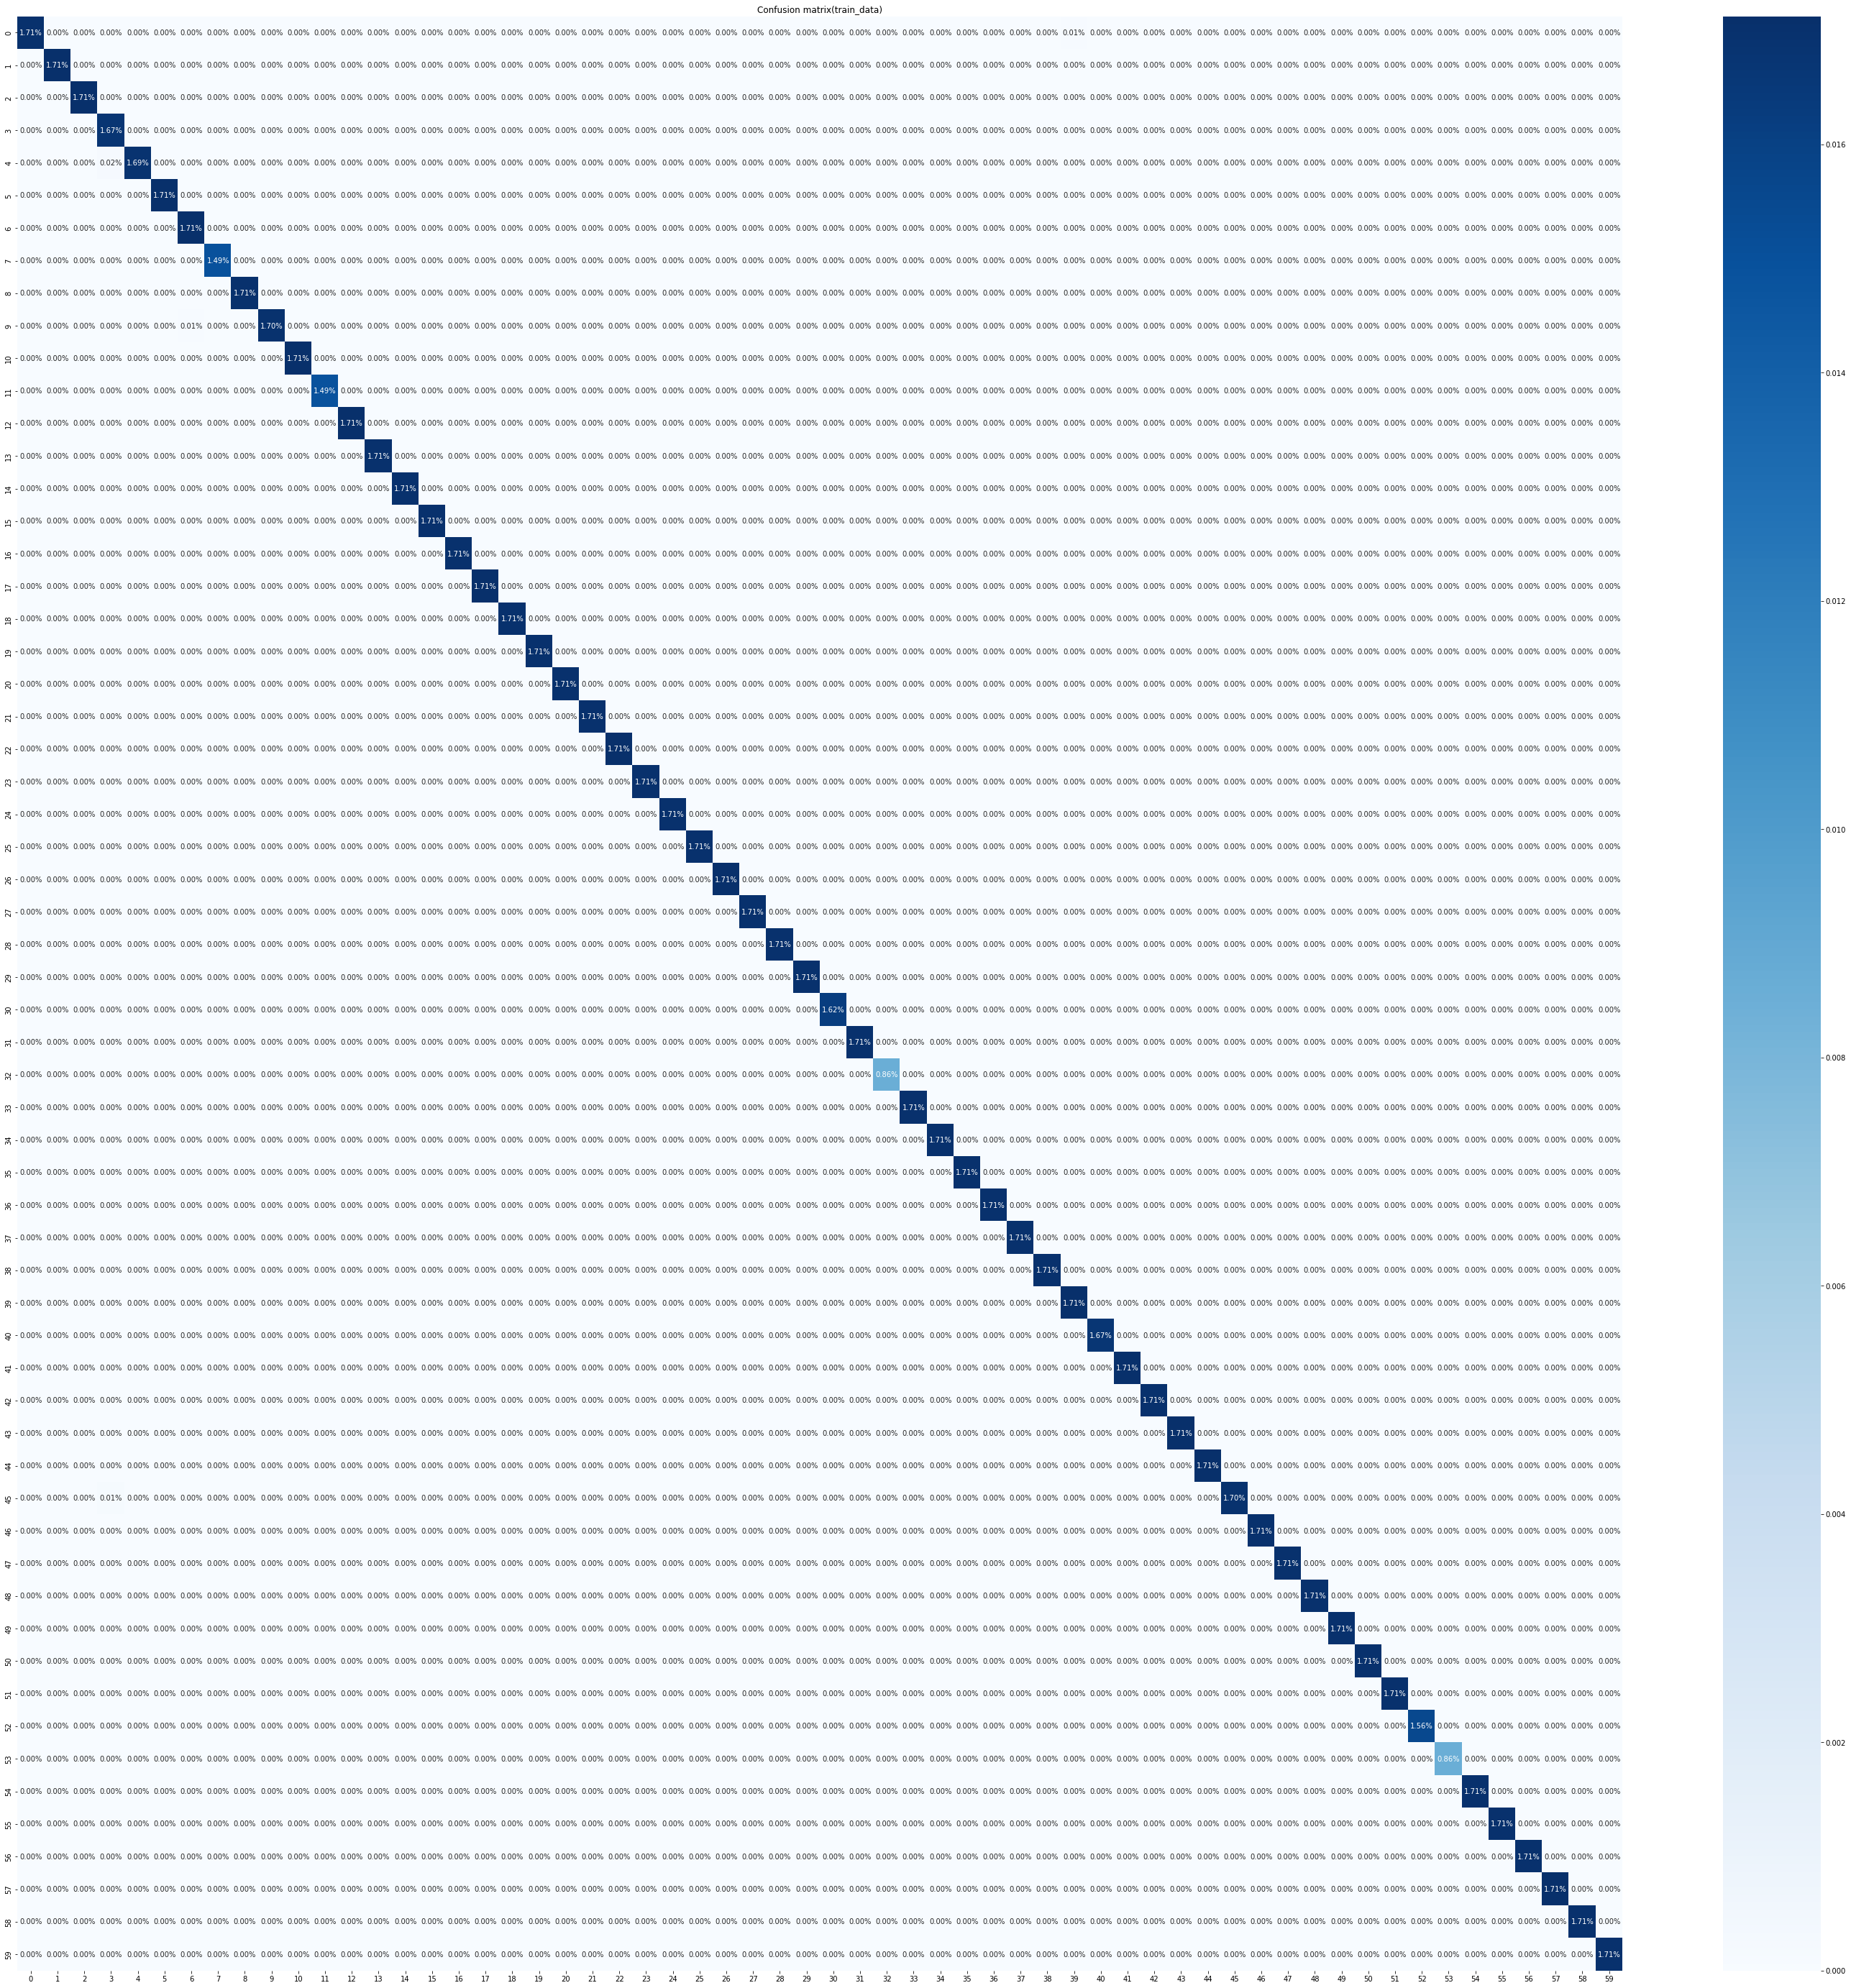

In [20]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(50,50))
plt.title('Confusion matrix(train_data)')
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues', ax=ax)

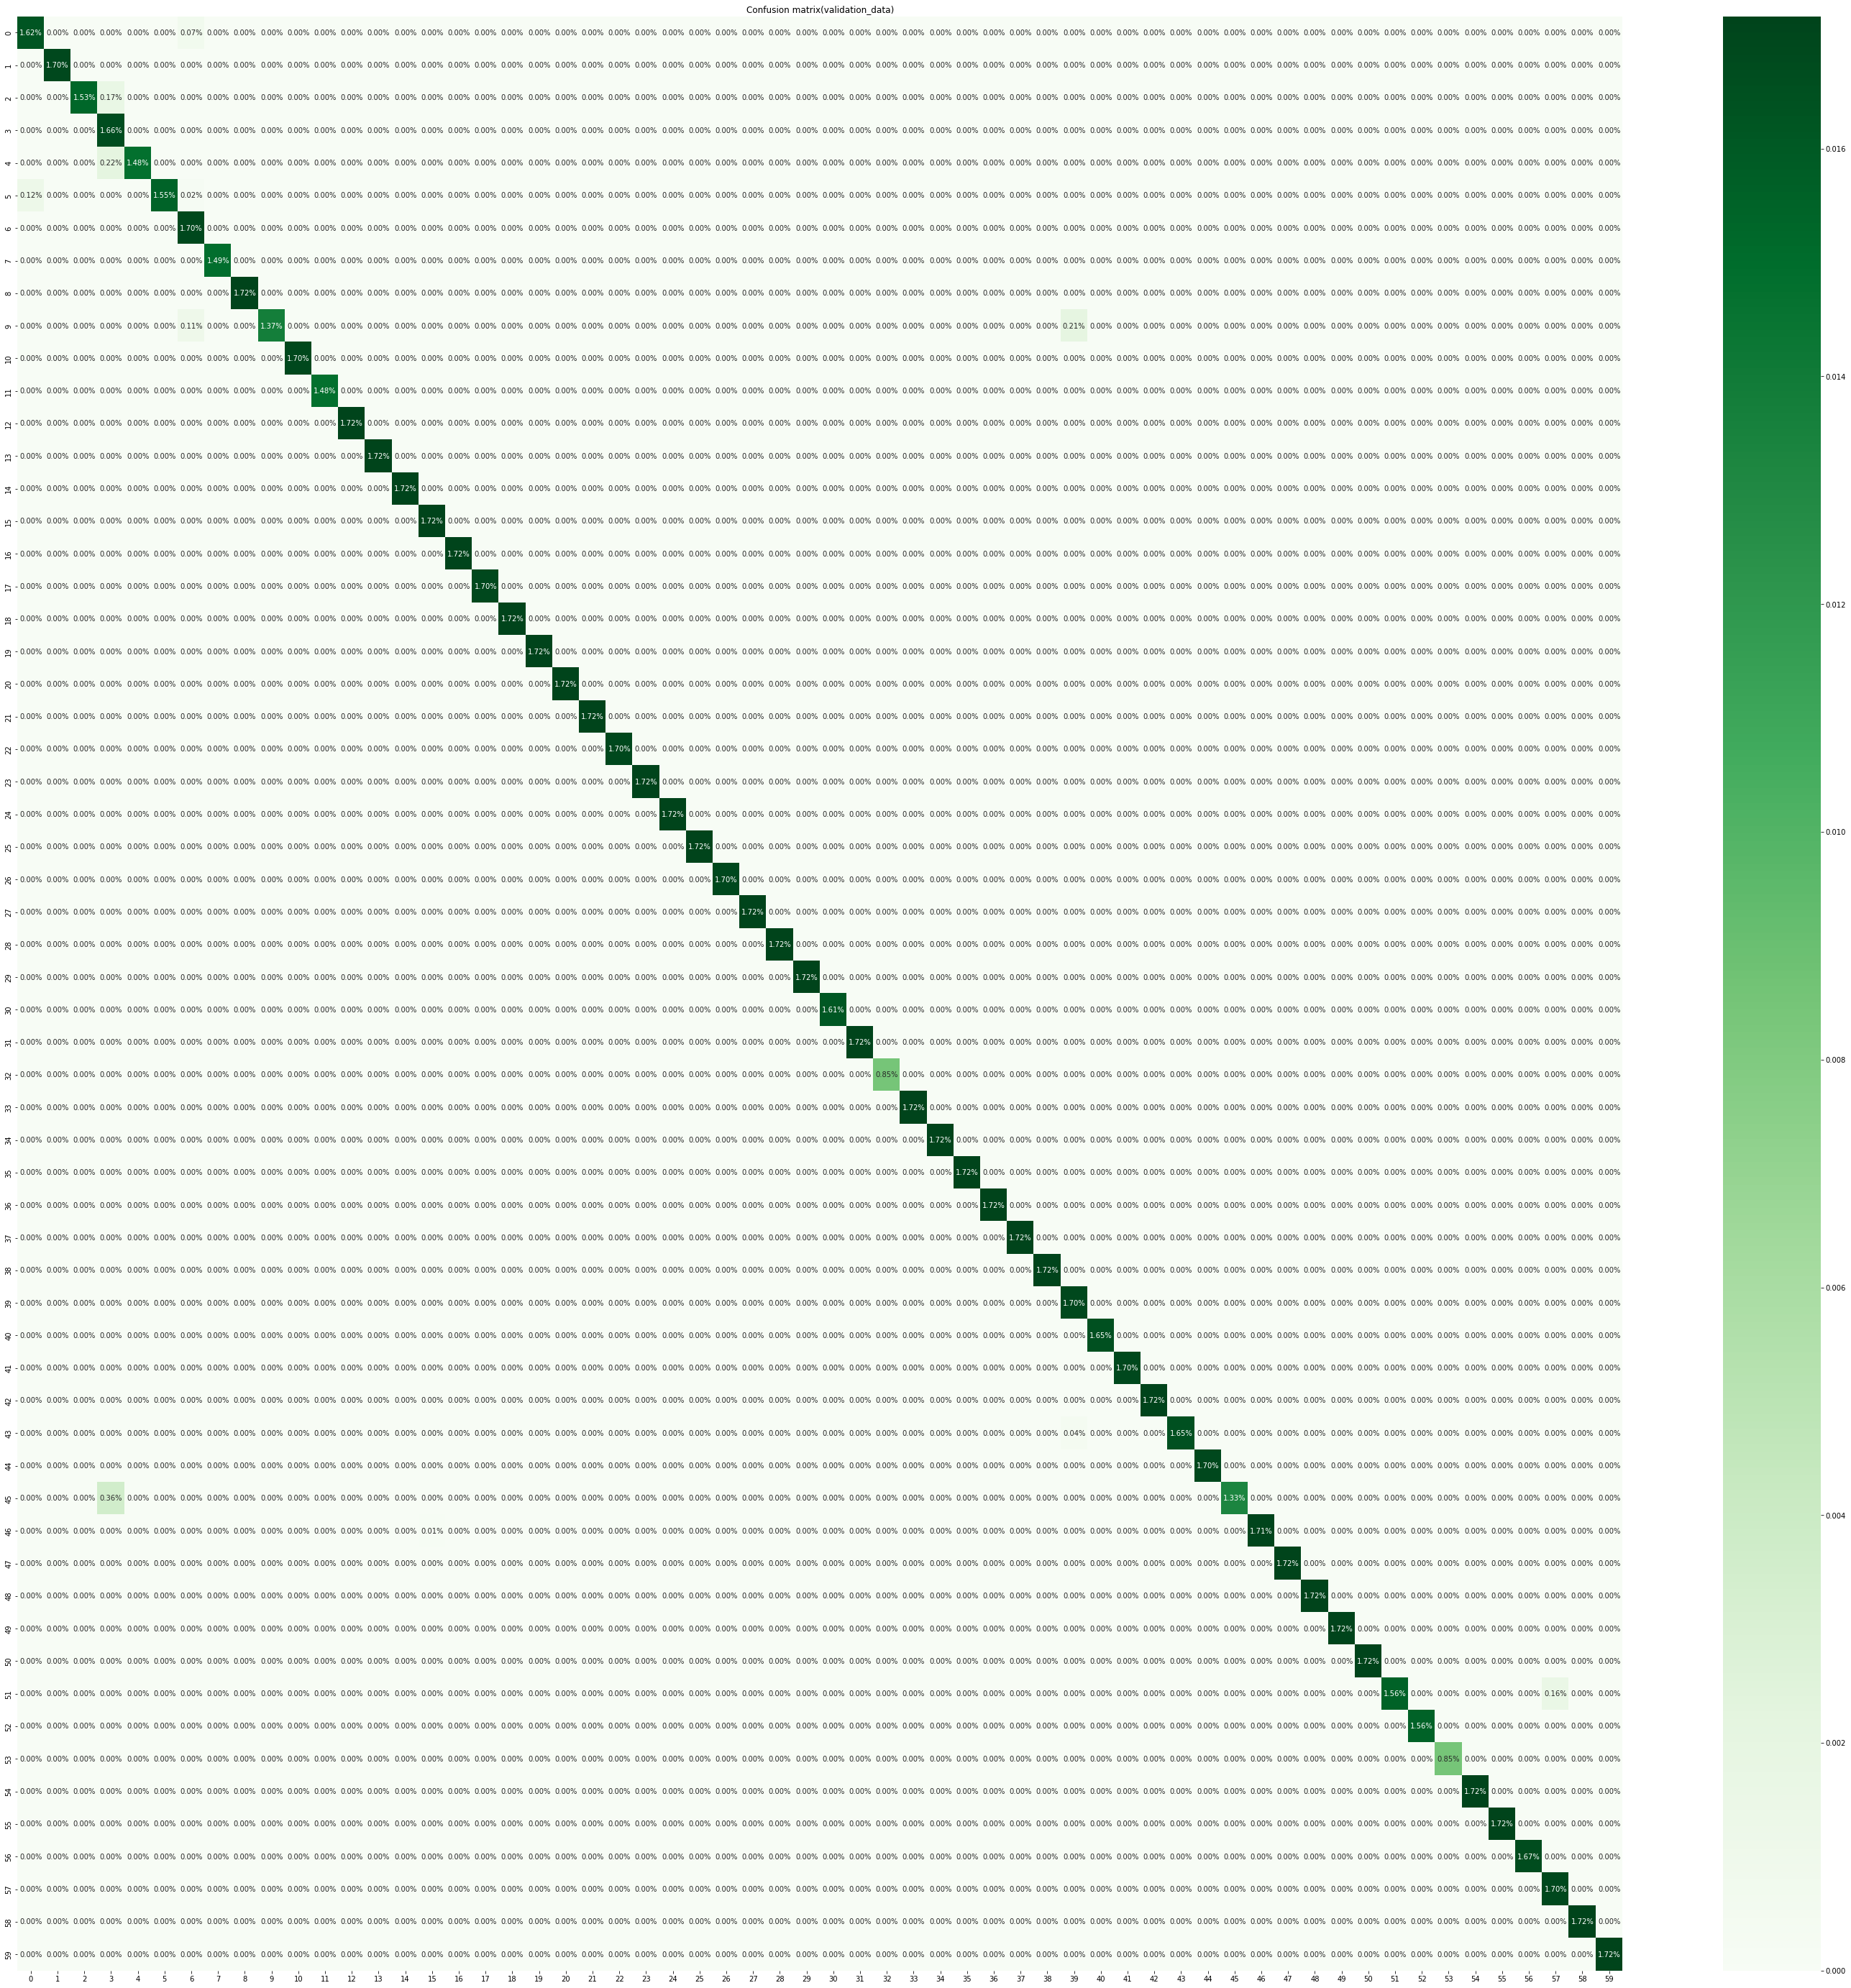

In [21]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(50,50))
plt.title('Confusion matrix(validation_data)')
sns.heatmap(valid_cm/np.sum(valid_cm), annot=True, 
            fmt='.2%', cmap='Greens', ax=ax)